# 1. Convolutional Neural Networks Visualization in Pytorch

In this kernel, we'll look into a convolutional network, to try and understand how they work by generating images that maximize the activation of the filters in the convolutional layers.
To generate these images, we apply gradient ascent to the inputs.

## Packages and utils functions

Some util functions to load and visualize images

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.optim import SGD
from torchvision import models, transforms
import PIL
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import scipy.ndimage as ndimage

%matplotlib inline

import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from io import BytesIO


def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def showtensor(a):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    showarray(inp)
    clear_output(wait=True)

def plot_images(im, titles=None):
    plt.figure(figsize=(30, 20))
    
    for i in range(len(im)):
        plt.subplot(10 / 5 + 1, 5, i + 1)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(im[i])
        
    plt.pause(0.001)
    
normalise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

normalise_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def init_image(size=(400, 400, 3)):
    img = PIL.Image.fromarray(np.uint8(np.full(size, 150)))
    img = PIL.Image.fromarray(np.uint8(np.random.uniform(150, 180, size)))
    img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def load_image(path, resize=False, size=None):
    img = PIL.Image.open(path)
    
    if size is not None:
        img.thumbnail(size, PIL.Image.ANTIALIAS)
        
    if resize:
        img_tensor = normalise_resize(img).unsqueeze(0)
    else:
        img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def tensor_to_img(t):
    a = t.numpy()
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    inp = np.uint8(np.clip(inp, 0, 255))
    return PIL.Image.fromarray(inp)

def image_to_variable(image, requires_grad=False, cuda=False):
    if cuda:
        image = Variable(image.cuda(), requires_grad=requires_grad)
    else:
        image = Variable(image, requires_grad=requires_grad)
    return image

## Filter Visualization

This function produces an image that maximizes the activation of the filter at *filter_index* in the layer *layer_index*. 

Usually when we train a Neural Net(NN), we use the following steps.
```
while not converge:
    take some inputs
    calucate predictions
    compute loss
    Do gradient descent on loss to update the weights in each layer
```
This procedure is shown in the following picture.
![](./pictures/nn_train.png)
After training a model, one interesting thing we want to do is that we would like to know what excatly each neuron in different layers look like. One way to do that is we start with inputting a picture with random pixels to the NN, and calculate the activations for the neuron that you want to visualize. Note that larger activations mean that the picture contains features that are closer to what is represented by this neuron, thus we want to maximize the activation. So after calculating the activation, we will do gradient ascent on the activation to update the input image.(All the gradients here are taken with respect to inputs, i.e. each pixel's value).

These are the steps described above.
```
intialize a random picture A
while not converge:
    Input A to the NN
    calucate activation for the specific neuron that you want to visualize
    Do gradient ascent on activation to update A
```
This procedure is shown in the following picture.
![](./pictures/filter_visualization.png)



In our exercise, we will use a pretrained model in pytorch called [VGG](https://arxiv.org/abs/1409.1556). 

In [2]:
model = models.vgg16()
model.load_state_dict(torch.load("./input/vgg16/vgg16.pth"))

<All keys matched successfully>

In [3]:
use_gpu = False
if torch.cuda.is_available():
    use_gpu = True

print(model)

for param in model.parameters():
    param.requires_grad = False

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Octaver Function

VGG model was trained on images of fairly low resolution, 224 * 224 pixels. So when we use images with much larger resolution, the algorithm described will create many small patterns instead of big ones. 

One solution is to downscale the input image to the same size. But such a low resolution is pixelated and ugly. 

Another solution is to repeatedly downscale the original image and run the algorithm on each of the smaller versions of the image. This creates larger patterns in the 
image that are then refined at the higher resolution. 

This flowchart shows roughly the idea. The algorithm is implemented recursively and supports any number of downscaling levels. 
![](./pictures/octaver_fn.png)

The function ```octaver_fn()``` implements what is described above.

In [4]:
# Finish this function
def octaver_fn(model, base_img, step_fn, octave_n=6, octave_scale=1.4, iter_n=10, **step_args):
    octaves = [base_img]
    # model: pretrained model
    # base_image: the image that you want to modify
    # step_fn: function for doing a single gradient ascent step
    # octave_n: how many times you want to zoom your picture
    # octave_scale: how much you want to zoom your picture each time
    # iter_n: num of gradient ascent steps you want to take 
    # step_args: a dictionary containing all the kwargs for step_fn
    for i in range(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)
        
        src = octave_base + detail
        
        for i in range(iter_n):
            src = step_fn(model, src, **step_args)

        detail = src.numpy() - octave_base

    return src

The following function ```filter_step()``` implements one single gradient ascent step.

In [5]:
def filter_step(model, img, layer_index, filter_index, step_size=0.05, display=True, use_L2=False):
    global use_gpu
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    model.zero_grad()
    
    img_var = image_to_variable(torch.Tensor(img), requires_grad=True, cuda=use_gpu)
    optimizer = SGD([img_var], lr=step_size, weight_decay=1e-4)
    
    x = img_var
    for index, layer in enumerate(model.features):
        x = layer(x)
        if index == layer_index:
            break

    output = x[0, filter_index]
    loss = output.norm()
    loss.backward()
    
    if use_L2:
        #L2 normalization on gradients
        mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2) + 1e-5])
        if use_gpu:
            mean_square = mean_square.cuda()
        img_var.grad.data /= torch.sqrt(mean_square)
        img_var.data.add_(img_var.grad.data * step_size)
    else:
        optimizer.step()
    
    result = img_var.data.cpu().numpy()
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    
    if display:
        showtensor(result)
    
    return torch.Tensor(result)

The function ```visualize_filter()``` visualize one single filter using ```octaver_fun()```.

In [6]:
def visualize_filter(model, base_img, layer_index, filter_index, 
                     octave_n=6, octave_scale=1.4, iter_n=10, 
                     step_size=0.05, display=True, use_L2=False):
    
    return octaver_fn(
                model, base_img, step_fn=filter_step, 
                octave_n=octave_n, octave_scale=octave_scale, 
                iter_n=iter_n, layer_index=layer_index, 
                filter_index=filter_index, step_size=step_size, 
                display=display, use_L2=use_L2
            )



The function ```show_layer()``` is a helper function to visualize a number of filters for a given layer.

In [7]:
def show_layer(layer_num, filter_start=10, filter_end=20, step_size=0.05, use_L2=False):
    filters = []
    titles = []
    
    _, _, img_np = init_image(size=(600, 600, 3))
    for i in range(filter_start, filter_end):
        title = "Layer {} Filter {}".format(layer_num , i)
        print(title)
        filter = visualize_filter(model, img_np, layer_num, filter_index=i, octave_n=2, iter_n=20, step_size=step_size, display=True, use_L2=use_L2)
        filter_img = tensor_to_img(filter)
        filters.append(tensor_to_img(filter))
        titles.append(title)
        
    
    plot_images(filters, titles)
    return filters, titles

Now you have finished all the functions you need to visualize some filters. Your task here is to use the functions above to visualize some filters in some layers.

In the following cell, visualize filter 11 to 15 in layer 1.

/Users/yixiaxia/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


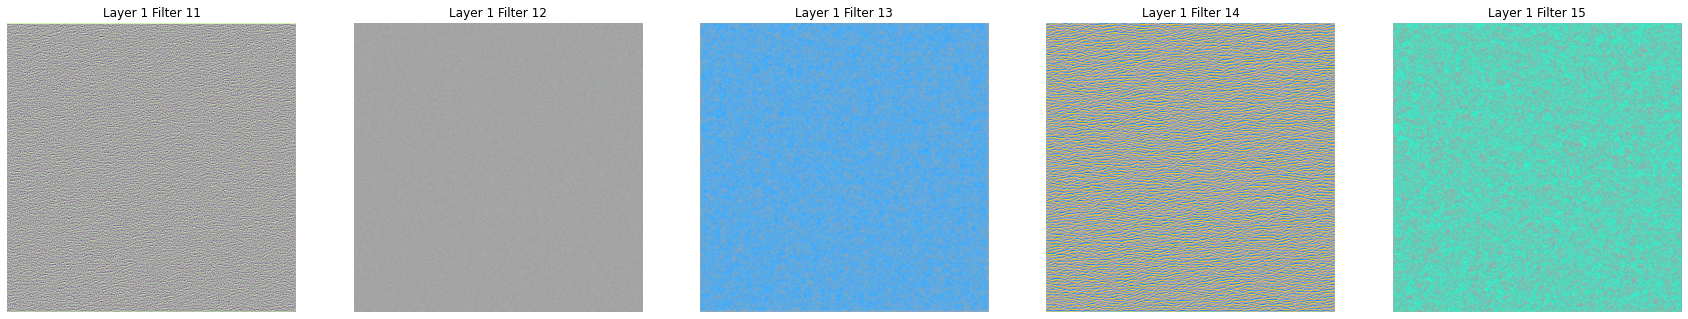

In [8]:
images, titles = show_layer(1, filter_start=11, filter_end=16, use_L2=True, step_size=0.05)

In the following cell, visualize filter 11 to 15 in layer 10 (This might take some time to run)

/Users/yixiaxia/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


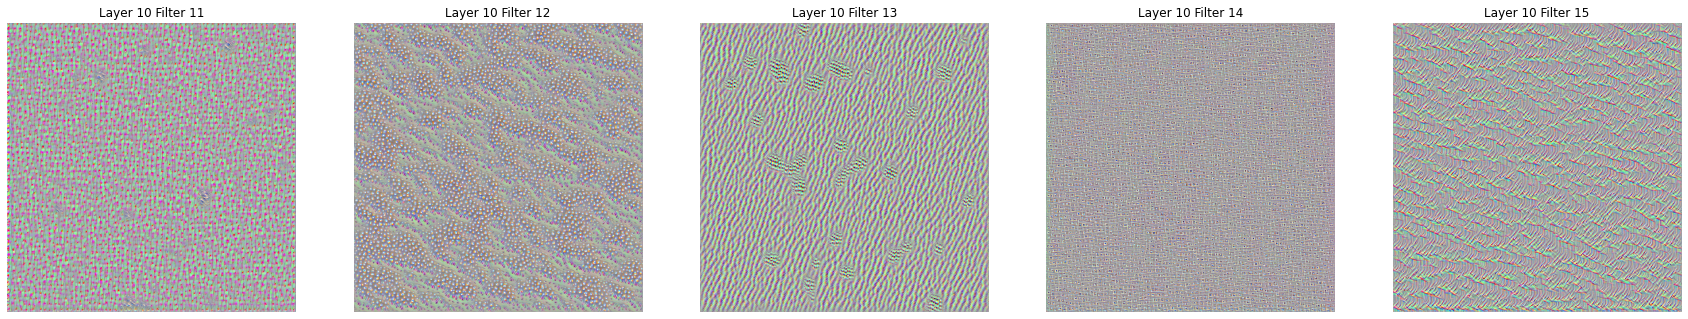

In [9]:
images, titles = show_layer(10, filter_start=11, filter_end=16, use_L2=True, step_size=0.05)

### Question: Compare your visualizations for layer 1 and layer 10, what's the difference in the patterns shown?

Layer1 produces simpler features(pure color) while layer10 produces more complex features which are ususally combinations of featurs generated in previous layers.

## Deep Dream

The Deep Dream function is similar to the filter visualization, but instead of starting from a random noise image, we start from an actual picture and try to maximize the network output. In this way, we're enhancing the features that the network recognizes in the image. 

The function ```make_step``` implements one single gradient ascent step for deap dream algorithm.

In [10]:
def objective(dst, guide_features):
    if guide_features is None:
        return dst.data
    else:
        x = dst.data[0].cpu().numpy()
        y = guide_features.data[0].cpu().numpy()
        ch, w, h = x.shape
        x = x.reshape(ch, -1)
        y = y.reshape(ch, -1)
        A = x.T.dot(y)
        diff = y[:, A.argmax(1)]
        diff = torch.Tensor(np.array([diff.reshape(ch, w, h)]))
        return diff

def make_step(model, img, objective=objective, control=None, step_size=1.5, end=28, jitter=32):
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    
    img = np.roll(np.roll(img, ox, -1), oy, -2)
    tensor = torch.Tensor(img) 
    
    img_var = image_to_variable(tensor, requires_grad=True, cuda=use_gpu)
    model.zero_grad()
      
    x = img_var
    for index, layer in enumerate(model.features.children()):
        x = layer(x)
        if index == end:
            break
    
    delta = objective(x, control)
    x.backward(delta)
    
    #L2 Regularization on gradients
    mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2)])
    img_var.grad.data /= torch.sqrt(mean_square)
    img_var.data.add_(img_var.grad.data * step_size)
    
    result = img_var.data.cpu().numpy()
    result = np.roll(np.roll(result, -ox, -1), -oy, -2)
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    showtensor(result)
    
    return torch.Tensor(result)

The function ```deepdream()``` is a wrapper function using the implemented ```octaver_fn()``` on the above step function.

In [11]:
def deepdream(model, base_img, octave_n=6, octave_scale=1.4, 
              iter_n=10, end=28, control=None, objective=objective, 
              step_size=1.5, jitter=32):
    
    return octaver_fn(
              model, base_img, step_fn=make_step, 
              octave_n=octave_n, octave_scale=octave_scale, 
              iter_n=iter_n, end=end, control=control,
              objective=objective, step_size=step_size, jitter=jitter
           )

Let's select a pciture and show it.

(1024, 682)


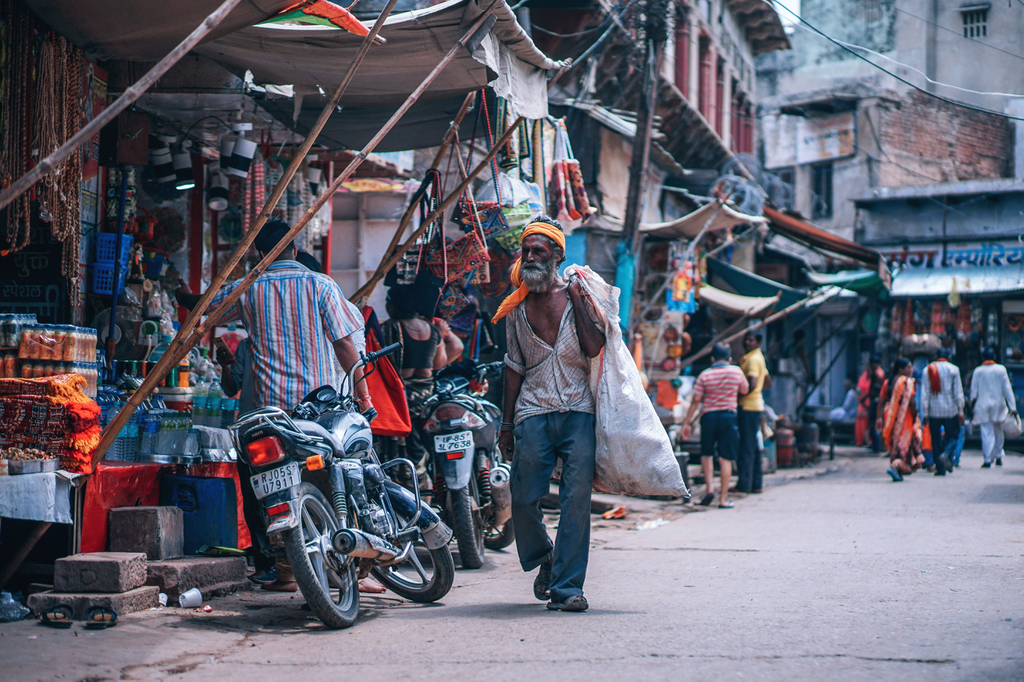

In [12]:
input_img, input_tensor, input_np = load_image('./input/data/market1.jpg', size=[1024, 1024])
print(input_img.size)
input_img

Then we apply the deepdream function on layer 14 on it to see the results.

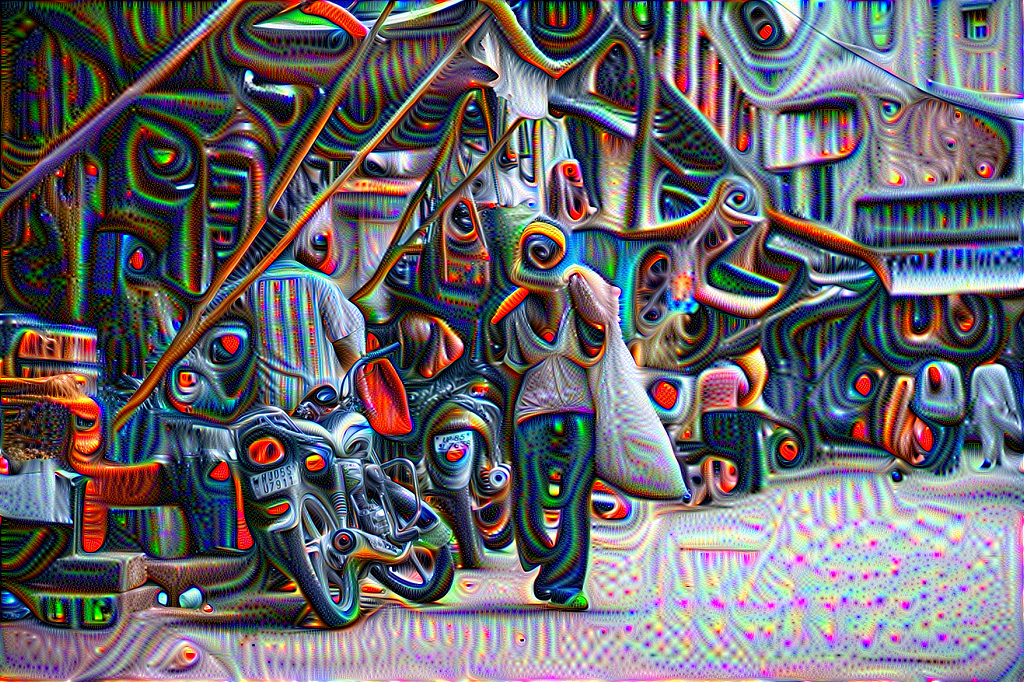

In [13]:
dream = deepdream(model, input_np, end=14, step_size=0.06, octave_n=6)
dream = tensor_to_img(dream)
dream

## Controlling the dream

We can control the dream by trying to alter the image in order to maximize the filters that are activated by another image (which we'll call guide). The idea would be we input the guide image into the NN and stops at the layer that you want to do deepdream on. The values you got are called guide features. Then when you input your picture which you want to do deepdream on, you would like to make the result on your chosen layer as close to the guide features as possible. (Actually this process has been implemented already, you just need to find out how to use it.)

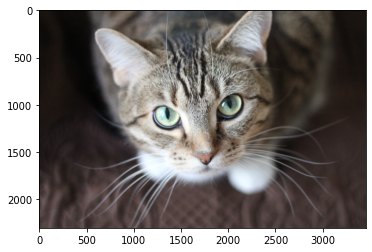

In [14]:
guide_img, guide_img_tensor, guide_img_np = load_image('./input/data/kitten2.jpg', resize=True)
plt.imshow(guide_img)

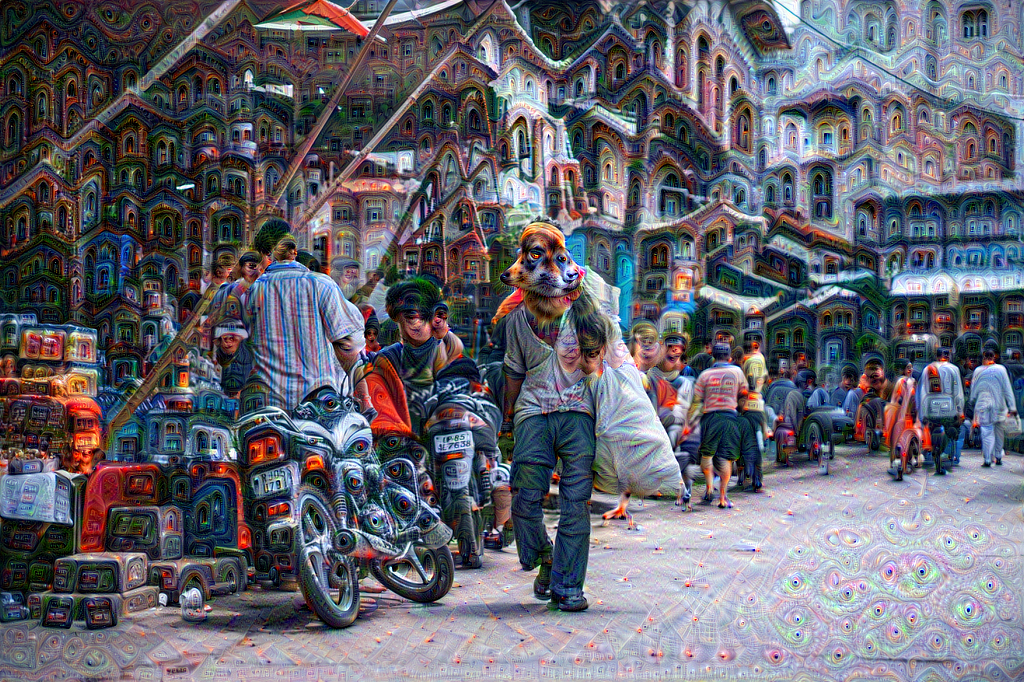

In [15]:
end = 26

guide_features = image_to_variable(guide_img_tensor, cuda=use_gpu)

for index, layer in enumerate(model.features.children()):
    guide_features = layer(guide_features)
    if index == end:
        break
    
dream = deepdream(model, input_np, end=end, step_size=0.06, octave_n=4, control=guide_features)
dream = tensor_to_img(dream)
dream.save('dream04.jpg')
dream

# 2. Feature selection using RF, PCA and Lasso

Here we are reusing the dataset from hw6.

In [16]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv("./datasets/VideoGameSales.csv")
df.head()

Name Platform  Year_of_Release  \
0                                EverGrace      PS2             2000   
1                               Spider-Man       PS             2000   
2  World Destruction League: Thunder Tanks       PS             2000   
3                                 The Sims       PC             2000   
4                       Street Fighter EX3      PS2             2000   

          Genre  Global_Sales  Critic_Score  Critic_Count  User_Score Rating  
0  Role-Playing          0.35            59            12         7.8      T  
1        Action          3.13            87            19         9.0      E  
2        Action          0.17            35             4         1.2      T  
3    Simulation          0.05            92            38         7.9      T  
4      Fighting          0.85            64            17         7.9      T

In [18]:
df = df.drop("Name", axis=1)
df.head()

Platform  Year_of_Release         Genre  Global_Sales  Critic_Score  \
0      PS2             2000  Role-Playing          0.35            59   
1       PS             2000        Action          3.13            87   
2       PS             2000        Action          0.17            35   
3       PC             2000    Simulation          0.05            92   
4      PS2             2000      Fighting          0.85            64   

   Critic_Count  User_Score Rating  
0            12         7.8      T  
1            19         9.0      E  
2             4         1.2      T  
3            38         7.9      T  
4            17         7.9      T

In [19]:
from sklearn.model_selection import train_test_split

y = df[["Global_Sales"]].values.ravel()

# Generate dummies for all catagrical features
X = pd.get_dummies(df.drop(["Global_Sales"], axis=1)).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)


print("Original:", X.shape)
print("Train:   ", X_train.shape,y_train.shape)
print("Test:    ", X_test.shape,y_test.shape)

Original: (6747, 39)
Train:    (5397, 39) (5397,)
Test:     (1350, 39) (1350,)


## 2.1 PCA

In this section you need to do the following:
 - Fit a PCA with 10 components
 - Draw a plot showing the explained variance ratio for each principle compoenent

In [20]:
from sklearn.decomposition import PCA

pca = PCA(10)
pca.fit(X_train)
principle_components = pca.transform(X_train)
pca.explained_variance_ratio_

array([7.31767981e-01, 2.46935610e-01, 1.49124357e-02, 2.12593349e-03,
       6.76147818e-04, 4.42560480e-04, 3.26799021e-04, 2.97754934e-04,
       2.75667615e-04, 2.15509846e-04])

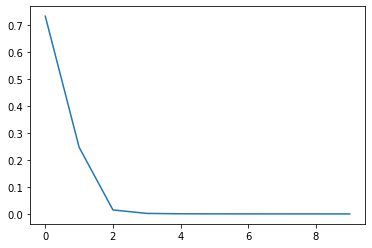

In [21]:
plt.plot(pca.explained_variance_ratio_[:10])

### Question: How would you determine the number of principle components to use?

We would choose PC1 and PC2 because PC2 is where the elbow appears.

## 2.2 Random Forest

In this section you need to do the following:
 - Fit a Random Forest
 - Draw a barchart showing the feature importance from RF for each feature

In [22]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)


RandomForestRegressor()

In [23]:
rf.feature_importances_

array([1.05574475e-01, 1.77557605e-01, 2.56211161e-01, 1.03580678e-01,
       3.00125036e-03, 8.33317002e-05, 3.18858053e-02, 9.34396133e-04,
       1.32234820e-03, 4.44366542e-03, 7.70736041e-04, 1.71207514e-02,
       5.39934513e-03, 0.00000000e+00, 2.55014898e-03, 1.17252702e-03,
       7.68541581e-02, 0.00000000e+00, 6.80979366e-03, 2.31237784e-03,
       0.00000000e+00, 5.07231567e-03, 1.20185540e-03, 2.83914017e-03,
       1.70972815e-02, 8.33083478e-03, 3.65714606e-03, 1.07996372e-02,
       4.66813833e-03, 5.94741492e-03, 5.54568444e-03, 6.64238883e-02,
       3.57089894e-04, 7.66062540e-06, 5.53321988e-02, 5.90245629e-03,
       5.32848800e-03, 1.16607885e-09, 3.90421260e-03])

<BarContainer object of 39 artists>

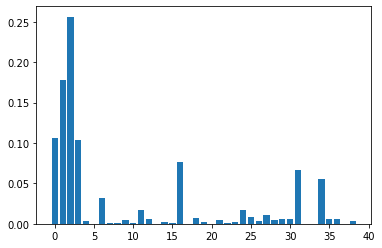

In [24]:
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)

### Question: According to feature importance, how would you select your features?

There are several ways to select features here, one way to do so is to set a threshold and delete features whose importance is less than the threshold.

## 2.3 Lasso

In this section you need to do the following:
 - Fit a Lasso with alpha=0.1
 - Draw a barchart showing the weights for each feature

In [25]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

Lasso(alpha=0.01)

<BarContainer object of 39 artists>

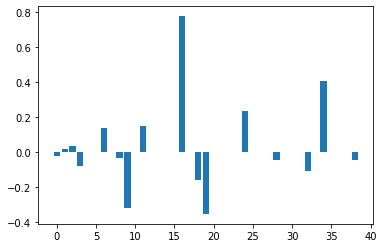

In [26]:
plt.bar(range(len(lasso.coef_)), lasso.coef_)

### Question: According to Lasso, what are the features that need to be deleted? Comparing with RF

Since Lasso can directly set coef to zero, it would be better we only delete features that have coef to be exactly zero as even the coef corresponding to a feature is very small(but not zero), this feature can still matter a lot to the model. In RF, feature importance directly shows how a feature affects the model, and that's why we can delete features according to a threshold.